In [14]:
from bs4 import BeautifulSoup
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import pickle
from IPython.display import display, Markdown
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

### MULTINOMIAL NAIVE BAYES

In [15]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1):
        self.alpha = alpha
        self.prior = None
        self.likelihood = None
        self.classes = None

    def fit(self, X, y):
        y = np.array(y)
        X = np.array(X)
        self.classes = np.unique(y)
        self.prior = np.zeros(len(self.classes))
        self.likelihood = np.zeros((len(self.classes), X.shape[1]))
        for i, c in enumerate(self.classes):
            self.prior[i] = np.sum(y == c) / len(y)
            self.likelihood[i] = (np.sum(X[y == c], axis=0) + self.alpha) / (np.sum(X[y == c]) + self.alpha * X.shape[1])

    def predict(self, X):
        X = np.array(X)
        return self.classes[np.argmax(np.log(self.prior) + X @ np.log(self.likelihood).T, axis=1)]

    def predict_proba(self, X):
        X = np.array(X)
        probs = np.zeros((X.shape[0], len(self.classes)))
        for i, c in enumerate(self.classes):
            probs[:, i] = np.log(self.prior[i]) + X @ np.log(self.likelihood[i]).T
        probs = np.exp(probs)
        probs = probs / np.sum(probs, axis=1).reshape(-1, 1)
        return probs

### MULTINOMIAL LOGISTIC REGRESSION

In [16]:
class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=100, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.loss = []
        self.weights = None
        self.bias = None
        
    def fit(self, x, y):
        x = np.array(x)
        y = np.array(y)
        self.loss = []
        self.weights = np.zeros((x.shape[1], len(np.unique(y))))
        self.bias = np.zeros(len(np.unique(y)))
        y = self.one_hot_encode(y)
        for i in range(self.max_iter):

            loss = self.cross_entropy_loss(x, y)
            self.loss.append(loss)

            dw, db = self.gradient(x, y)
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if loss < self.tol:
                break
        return self
    
    def predict(self, x):
        probs = self.softmax(x)
        return np.argmax(probs, axis=1)
    
    def predict_proba(self, x):
        return self.softmax(x)
    
    def softmax(self, x):
        scores = np.dot(x, self.weights) + self.bias
        probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
        return probs
    
    def cross_entropy_loss(self, x, y):
        probs = self.softmax(x)
        loss = -np.sum(y * np.log(probs)) / len(x)
        return loss
    
    def gradient(self, x, y):
        probs = self.softmax(x)
        dw = np.dot(x.T, (probs - y)) / len(x)
        db = np.sum(probs - y) / len(x)
        return dw, db
    
    def one_hot_encode(self, y):
        y = np.eye(len(np.unique(y)))[y]
        return y

### FUNCTIONS FOR PROCESSING TEXT

In [17]:
# function to get text from the .html file
def get_text(html_file):
    with open(html_file, 'r', encoding='iso-8859-1') as f:
        soup = BeautifulSoup(f, 'html.parser')
        text = soup.get_text()
        text = text.replace('\n', ' ')
        text = ' '.join(text.split())
    return text

# function to get the bag of words from list of text using count vectorizer
def get_bag_of_words(text_list):
    corpus = []
    vocab = []
    for text in text_list:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        #lemmatisation  
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
        text = ' '.join(text)
        corpus.append(text)
        vocab.extend(text.split())
    vocab = list(set(vocab))
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(corpus)
    tfidf_transformer = TfidfTransformer()
    bag_of_words = tfidf_transformer.fit_transform(bag_of_words)
    return bag_of_words, vocab

### FUNCTION FOR ACCURACY

In [18]:
def accuracy(X_test, y_test, clf_fulltext,clf_inlinks,flag=0):
    X_test_fulltext = []
    X_test_inlinks = []

    for i in range(len(X_test)):
        X_test_fulltext.append(X_test[i]['view1'])
        X_test_inlinks.append(X_test[i]['view2'])

    y_pred_fulltext = clf_fulltext.predict_proba(X_test_fulltext)
    y_pred_inlinks = clf_inlinks.predict_proba(X_test_inlinks)

    # calculating the accuracy by taking the maximum of the probabilities of the two classifiers

    y_pred = []
    for i in range(len(y_pred_fulltext)):
        # maximum probability from fulltext classifier
        max_prob1 = max(y_pred_fulltext[i])
        index1 = np.argmax(y_pred_fulltext[i])
        # maximum probability from inlinks classifier
        max_prob2 = max(y_pred_inlinks[i])
        index2 = np.argmax(y_pred_inlinks[i])
        # taking the maximum of the two probabilities
        if max_prob1 > max_prob2:
            y_pred.append(index1)
        else:
            if flag==1:
                y_pred.append(1-index2)
            else:
                y_pred.append(index2)

    # calculating the accuracy
    count = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            count += 1
    
    acc = count/len(y_pred)
    pre = precision_score(y_test, y_pred, average='macro',zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro',zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro',zero_division=0)
    
    return acc,pre,rec,f1

### COTRAINING ALGORITHM FOR BINARY CLASSIFICATION

In [66]:
# cotraining algorithm
def cotrain_binary(p,n,k,u,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks,flag=0, save = 0, k_save = 30, file_name = ""):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for _ in range(k):
        fulltext_t = []
        inlinks_t = []

        for i in range(len(X_train_L)):
            fulltext_t.append(X_train_L[i]['view1'])
            inlinks_t.append(X_train_L[i]['view2'])

        # Training the classifiers on the labeled data
        clf_fulltext.fit(fulltext_t, y_train_L)
        if flag == 1:
            y_ = [1 - value for value in y_train_L]
            clf_inlinks.fit(inlinks_t, y_)
        else:
            clf_inlinks.fit(inlinks_t, y_train_L)

        # randomly selecting u examples from U
        X_train_U_sample = []
        y_train_U_sample = []

        for i in range(u):
            index = np.random.randint(len(X_train_U))
            X_train_U_sample.append(X_train_U[index])
            y_train_U_sample.append(y_train_U[index])

        X_train_U_sample_fulltext = []
        X_train_U_sample_inlinks = []

        for i in range(len(X_train_U_sample)):
            X_train_U_sample_fulltext.append(X_train_U_sample[i]['view1'])
            X_train_U_sample_inlinks.append(X_train_U_sample[i]['view2'])

        y_pred_fulltext = clf_fulltext.predict_proba(X_train_U_sample_fulltext)
        y_pred_inlinks = clf_inlinks.predict_proba(X_train_U_sample_inlinks)

        # adding the most confident n negative examples to L
        for i in range(n):
            index = np.argmax(y_pred_fulltext[:,0])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_fulltext = np.delete(y_pred_fulltext,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)


        # adding the most confident p positive examples to L
        for i in range(p):
            index = np.argmax(y_pred_fulltext[:,1])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_fulltext = np.delete(y_pred_fulltext,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)

        # adding the most confident n negative examples to L
        if flag == 1:
            r = p
        else:
            r = n

        for i in range(r):
            index = np.argmax(y_pred_inlinks[:,0])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)

        # adding the most confident p positive examples to L
        if flag == 1:
            r = n
        else:
            r = p

        for i in range(r):
            index = np.argmax(y_pred_inlinks[:,1])
            X_train_L.append(X_train_U_sample[index])
            y_train_L.append(y_train_U_sample[index])
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)
            X_train_U_sample = np.delete(X_train_U_sample,index,0)
            y_train_U_sample = np.delete(y_train_U_sample,index,0)

        if(save and _ == k_save):
          filename = file_name+"_view-1"
          pickle.dump(clf_fulltext, open(filename, 'wb'))
          filename = file_name+"_view-2"
          pickle.dump(clf_inlinks,open(filename, 'wb'))


        # calculating the accuracy
        acc,pre,rec,f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks,flag)
        accuracy_list.append(acc)
        precision_list.append(pre)
        recall_list.append(rec)
        f1_list.append(f1)

    return clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list

### SELF-TRAINING ALGORITHM FOR BINARY CLASSIFICATION

In [67]:
def self_training_binary(p,n,k,u,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks,flag=0):
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []
    # deep copy of the labeled data
    X_train_L1 = X_train_L.copy()
    y_train_L1 = y_train_L.copy()

    X_train_L2 = X_train_L.copy()
    y_train_L2 = y_train_L.copy()

    for _ in range(k):
        fulltext_t = []
        inlinks_t = []

        for i in range(len(X_train_L1)):
            fulltext_t.append(X_train_L1[i]['view1'])
            inlinks_t.append(X_train_L2[i]['view2'])

        # Training the classifiers on the labeled data
        clf_fulltext.fit(fulltext_t, y_train_L1)
        if flag == 1:
            y_ = [1 - value for value in y_train_L2]
            clf_inlinks.fit(inlinks_t, y_)
        else:
            clf_inlinks.fit(inlinks_t, y_train_L2)

        # randomly select u examples from U
        X_train_U_sample1 = []
        y_train_U_sample1 = []
        X_train_U_sample2 = []
        y_train_U_sample2 = []

        for i in range(u):
            index = np.random.randint(len(X_train_U))
            X_train_U_sample1.append(X_train_U[index])
            y_train_U_sample1.append(y_train_U[index])

        for i in range(u):
            index = np.random.randint(len(X_train_U))
            X_train_U_sample2.append(X_train_U[index])
            y_train_U_sample2.append(y_train_U[index])

        X_train_U_sample_fulltext = []
        X_train_U_sample_inlinks = []

        for i in range(len(X_train_U_sample1)):
            X_train_U_sample_fulltext.append(X_train_U_sample1[i]['view1'])
            X_train_U_sample_inlinks.append(X_train_U_sample2[i]['view2'])
        
        y_pred_fulltext = clf_fulltext.predict_proba(X_train_U_sample_fulltext)
        y_pred_inlinks = clf_inlinks.predict_proba(X_train_U_sample_inlinks)

        for i in range(n):
            index = np.argmax(y_pred_fulltext[:,0])
            X_train_L1.append(X_train_U_sample1[index])
            y_train_L1.append(y_train_U_sample1[index])
            y_pred_fulltext = np.delete(y_pred_fulltext,index,0)
            X_train_U_sample1 = np.delete(X_train_U_sample1,index,0)
            y_train_U_sample1 = np.delete(y_train_U_sample1,index,0)
        
        for i in range(p):
            index = np.argmax(y_pred_fulltext[:,1])
            X_train_L1.append(X_train_U_sample1[index])
            y_train_L1.append(y_train_U_sample1[index])
            y_pred_fulltext = np.delete(y_pred_fulltext,index,0)
            X_train_U_sample1 = np.delete(X_train_U_sample1,index,0)
            y_train_U_sample1 = np.delete(y_train_U_sample1,index,0)

        if flag == 1:
            r = p
        else:
            r = n

        for i in range(r):
            index = np.argmax(y_pred_inlinks[:,0])
            X_train_L2.append(X_train_U_sample2[index])
            y_train_L2.append(y_train_U_sample2[index])            
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)
            X_train_U_sample2 = np.delete(X_train_U_sample2,index,0)
            y_train_U_sample2 = np.delete(y_train_U_sample2,index,0)

        # adding the most confident p positive examples to L
        if flag == 1:
            r = n
        else:
            r = p

        for i in range(r):
            index = np.argmax(y_pred_inlinks[:,1])
            X_train_L2.append(X_train_U_sample2[index])
            y_train_L2.append(y_train_U_sample2[index])
            y_pred_inlinks = np.delete(y_pred_inlinks,index,0)
            X_train_U_sample2 = np.delete(X_train_U_sample2,index,0)
            y_train_U_sample2 = np.delete(y_train_U_sample2,index,0)
        
        # calculating the accuracy
        acc,pre,rec,f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks,flag)
        accuracy_list.append(acc)
        precision_list.append(pre)
        recall_list.append(rec)
        f1_list.append(f1)
            
    return clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list

### COTRAINING ALGORITHM FOR MULTI-CLASS CLASSIFICATION

In [21]:
def cotrain_multi_class(arr,k,u,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks,save=0,k_save=30,file_name=""):
    X_train_L__fulltext = X_train_L
    X_train_L__inlinks = X_train_L
    y_train_L__fulltext = y_train_L
    y_train_L__inlinks = y_train_L
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for _ in range(k):

        fulltext_t = []
        inlinks_t = []

        for i in range(len(X_train_L__fulltext)):
            fulltext_t.append(X_train_L__fulltext[i]['view1'])
        
        for i in range(len(X_train_L__inlinks)):
            inlinks_t.append(X_train_L__inlinks[i]['view2'])
        
        clf_fulltext.fit(fulltext_t,y_train_L__fulltext)
        clf_inlinks.fit(inlinks_t,y_train_L__inlinks)

        # randomly selecting u examples from U
        X_train_U_sample_f = []
        y_train_U_sample_f = []
        X_train_U_sample_i = []
        y_train_U_sample_i = []

        for i in range(u):
            # randomly taking u unique examples from U
            index = np.random.randint(len(X_train_U))
            X_train_U_sample_f.append(X_train_U[index])
            y_train_U_sample_f.append(y_train_U[index])
            X_train_U_sample_i.append(X_train_U[index])
            y_train_U_sample_i.append(y_train_U[index])
        
        X_train_U_sample_fulltext = []
        X_train_U_sample_inlinks = []

        for i in range(len(X_train_U_sample_f)):
            X_train_U_sample_fulltext.append(X_train_U_sample_f[i]['view1'])
            X_train_U_sample_inlinks.append(X_train_U_sample_f[i]['view2'])
        
        y_pred_fulltext = clf_fulltext.predict_proba(X_train_U_sample_fulltext)
        y_pred_inlinks = clf_inlinks.predict_proba(X_train_U_sample_inlinks)

        # adding the most confident a 0's, b 1's, c 2's, d 3's, e 4's to X_train_L__fulltext and X_train_L__inlinks
        for i in range(len(arr)):
            for j in range(arr[i]):
                index = np.argmax(y_pred_fulltext[:,i])
                X_train_L__inlinks.append(X_train_U_sample_f[index])
                y_train_L__inlinks.append(y_train_U_sample_f[index])
                y_pred_fulltext = np.delete(y_pred_fulltext,index,axis=0)
                X_train_U_sample_f = np.delete(X_train_U_sample_f,index,axis=0)
                y_train_U_sample_f = np.delete(y_train_U_sample_f,index,axis=0)

        for i in range(len(arr)):
            for j in range(arr[i]):
                index = np.argmax(y_pred_inlinks[:,i])
                X_train_L__fulltext.append(X_train_U_sample_i[index])
                y_train_L__fulltext.append(y_train_U_sample_i[index])
                y_pred_inlinks = np.delete(y_pred_inlinks,index,axis=0)
                X_train_U_sample_i = np.delete(X_train_U_sample_i,index,axis=0)
                y_train_U_sample_i = np.delete(y_train_U_sample_i,index,axis=0)

        if(save and _ == k_save):
          filename = file_name+"_view-1"
          pickle.dump(clf_fulltext, open(filename, 'wb'))
          filename = file_name+"_view-2"
          pickle.dump(clf_inlinks,open(filename, 'wb'))
        
        # calculating the accuracy
        acc,pre,rec,f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks)
        accuracy_list.append(acc)
        precision_list.append(pre)
        recall_list.append(rec)
        f1_list.append(f1)

    return clf_fulltext,clf_inlinks,accuracy_list,precision_list,recall_list,f1_list

### SELF-TRAINING ALGORITHM FOR MULTI-CLASS CLASSIFICATION

In [68]:
def self_train_multi_class(arr,k,u,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks):
    X_train_L__fulltext = X_train_L
    X_train_L__inlinks = X_train_L
    y_train_L__fulltext = y_train_L
    y_train_L__inlinks = y_train_L
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for _ in range(k):

        fulltext_t = []
        inlinks_t = []

        for i in range(len(X_train_L__fulltext)):
            fulltext_t.append(X_train_L__fulltext[i]['view1'])
        
        for i in range(len(X_train_L__inlinks)):
            inlinks_t.append(X_train_L__inlinks[i]['view2'])
        
        clf_fulltext.fit(fulltext_t,y_train_L__fulltext)
        clf_inlinks.fit(inlinks_t,y_train_L__inlinks)

        # randomly select u examples from U
        X_train_U_sample_f = []
        y_train_U_sample_f = []
        X_train_U_sample_i = []
        y_train_U_sample_i = []

        for i in range(u):
            # randomly taking u unique examples from U
            index = np.random.randint(len(X_train_U))
            X_train_U_sample_f.append(X_train_U[index])
            y_train_U_sample_f.append(y_train_U[index])
            X_train_U_sample_i.append(X_train_U[index])
            y_train_U_sample_i.append(y_train_U[index])
        
        X_train_U_sample_fulltext = []
        X_train_U_sample_inlinks = []

        for i in range(len(X_train_U_sample_f)):
            X_train_U_sample_fulltext.append(X_train_U_sample_f[i]['view1'])
            X_train_U_sample_inlinks.append(X_train_U_sample_f[i]['view2'])
        
        y_pred_fulltext = clf_fulltext.predict_proba(X_train_U_sample_fulltext)
        y_pred_inlinks = clf_inlinks.predict_proba(X_train_U_sample_inlinks)

        # adding the most confident a 0's, b 1's, c 2's, d 3's, e 4's to X_train_L__fulltext and X_train_L__inlinks
        for i in range(len(arr)):
            for j in range(arr[i]):
                index = np.argmax(y_pred_fulltext[:,i])
                X_train_L__fulltext.append(X_train_U_sample_f[index])
                y_train_L__fulltext.append(y_train_U_sample_f[index])
                y_pred_fulltext = np.delete(y_pred_fulltext,index,axis=0)
                X_train_U_sample_f = np.delete(X_train_U_sample_f,index,axis=0)
                y_train_U_sample_f = np.delete(y_train_U_sample_f,index,axis=0)

        for i in range(len(arr)):
            for j in range(arr[i]):
                index = np.argmax(y_pred_inlinks[:,i])
                X_train_L__inlinks.append(X_train_U_sample_i[index])
                y_train_L__inlinks.append(y_train_U_sample_i[index])
                y_pred_inlinks = np.delete(y_pred_inlinks,index,axis=0)
                X_train_U_sample_i = np.delete(X_train_U_sample_i,index,axis=0)
                y_train_U_sample_i = np.delete(y_train_U_sample_i,index,axis=0)
        
        # calculating the accuracy
        acc,pre,rec,f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks)
        accuracy_list.append(acc)
        precision_list.append(pre)
        recall_list.append(rec)
        f1_list.append(f1)

    return clf_fulltext,clf_inlinks,accuracy_list,precision_list,recall_list,f1_list

### WEB DATA (BINARY)

In [72]:
X_fulltext = []
y_fulltext = []
X_inlinks = []
y_inlinks = []


for filename in os.listdir('data/course-cotrain-data/fulltext/course'):
    X_fulltext.append(get_text('data/course-cotrain-data/fulltext/course/'+filename))
    y_fulltext.append('course')

for filename in os.listdir('data/course-cotrain-data/fulltext/non-course'):
    X_fulltext.append(get_text('data/course-cotrain-data/fulltext/non-course/'+filename))
    y_fulltext.append('noncourse')

for filename in os.listdir('data/course-cotrain-data/inlinks/course'):
    X_inlinks.append(get_text('data/course-cotrain-data/inlinks/course/'+filename))
    y_inlinks.append('course')

for filename in os.listdir('data/course-cotrain-data/inlinks/non-course'):
    X_inlinks.append(get_text('data/course-cotrain-data/inlinks/non-course/'+filename))
    y_inlinks.append('noncourse')

X_fulltext,vocab_fulltext = get_bag_of_words(X_fulltext)
X_inlinks,vocab_inlinks = get_bag_of_words(X_inlinks)

X_fulltext = X_fulltext.toarray()
X_inlinks = X_inlinks.toarray()

y_fulltext = [1 if x=='course' else 0 for x in y_fulltext]
y_inlinks = [1 if x=='course' else 0 for x in y_inlinks]

y_fulltext = np.array(y_fulltext)
y_inlinks = np.array(y_inlinks)


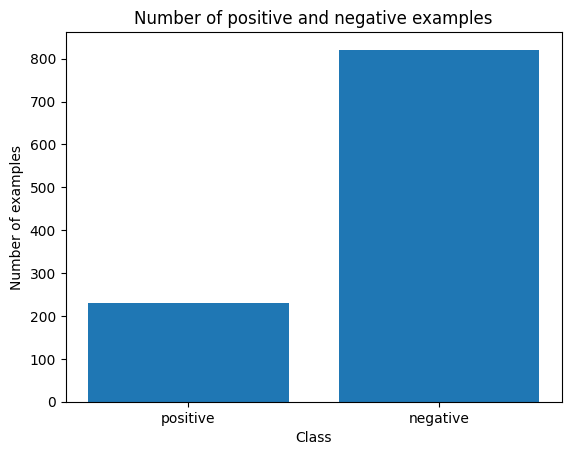

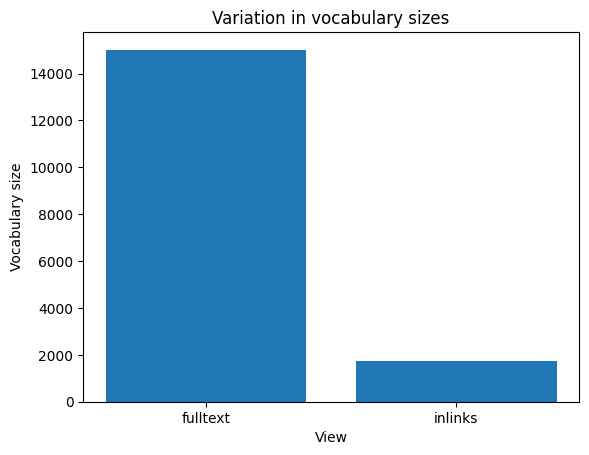

In [73]:
import matplotlib.pyplot as plt
plt.bar(['positive','negative'],[np.sum(y_fulltext),len(y_fulltext)-np.sum(y_fulltext)])
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Number of positive and negative examples')
plt.show()

plt.bar(['fulltext','inlinks'],[len(vocab_fulltext),len(vocab_inlinks)])
plt.xlabel('View')
plt.ylabel('Vocabulary size')
plt.title('Variation in vocabulary sizes')
plt.show()

In [74]:
data = {'x':[], 'y':[]}
for i in range(X_fulltext.shape[0]):
    data['x'].append({'view1':X_fulltext[i],'view2':X_inlinks[i]})
    data['y'].append(y_fulltext[i])

X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=0,shuffle=True)

In [75]:
# diving X_train into L and U : L has 9 non-course(0) and 3 course(1) and U has the rest
X_train_L = []
X_train_L1 = []
X_train_U = []
y_train_L = []
y_train_L1 = []
y_train_U = []

count_0 = 0
count_1 = 0

for i in range(len(X_train)):
    if y_train[i] == 0 and count_0 < 9:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count_0 += 1
    elif y_train[i] == 1 and count_1 < 3:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count_1 += 1
    else:
        X_train_U.append(X_train[i])
        y_train_U.append(y_train[i])

In [ ]:
# varying the number of positive and negative examples in each iteration using sweep
import wandb

sweep_config = {
    'method': 'grid',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'p': {
            'values': [1,2,3]
        },
        'n': {
            'values': [1,2,3]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="course-cotrain")

def train():
    with wandb.init():
        config = wandb.config
        clf_fulltext = MultinomialNaiveBayes()
        clf_inlinks = MultinomialNaiveBayes()
        X_train_dup = X_train_L.copy()
        y_train_dup = y_train_L.copy()
        clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list = cotrain_binary(config.p,config.n,50,75,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks)
        wandb.log({"accuracy":accuracy_list[-1],"precision":precision_list[-1],"recall":recall_list[-1],"f1":f1_list[-1]})
        return accuracy_list[-1]
    
wandb.agent(sweep_id, train)

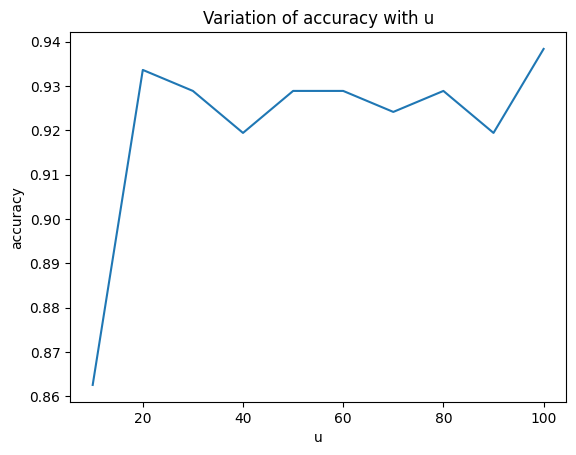

In [28]:
# varying u 
u = [10,20,30,40,50,60,70,80,90,100]
a = []
for i in u:
    clf_fulltext = MultinomialNaiveBayes()
    clf_inlinks = MultinomialNaiveBayes()
    X_train_dup = X_train_L.copy()
    y_train_dup = y_train_L.copy()
    clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list = cotrain_binary(1,3,30,i,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks)
    a.append(accuracy_list[-1])

plt.plot(u,a)
plt.xlabel('u')
plt.ylabel('accuracy')
plt.title('Variation of accuracy with u')
plt.show()

In [29]:
df = pd.DataFrame(columns=['Algorithm','page-based','link-based','combined'])
from sklearn.metrics import accuracy_score

# co-training
clf_fulltext = MultinomialNaiveBayes()
clf_inlinks = MultinomialNaiveBayes()
X_train_dup = X_train_L.copy()
y_train_dup = y_train_L.copy()
clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list = cotrain_binary(1,3,30,75,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltext,clf_inlinks)
fulltext = []
inlinks = []

for i in range(len(X_test)):
    fulltext.append(X_test[i]['view1'])
    inlinks.append(X_test[i]['view2'])

y_pred_fulltext = clf_fulltext.predict(fulltext)
y_pred_inlinks = clf_inlinks.predict(inlinks)

acc_f = accuracy_score(y_test,y_pred_fulltext)
acc_i = accuracy_score(y_test,y_pred_inlinks)

df = df._append({'Algorithm':'co-training','page-based':(1-acc_f)*100,'link-based':(1-acc_i)*100,'combined':(1-accuracy_list[-1])*100},ignore_index=True)

# supervised learning
clf_fulltext = MultinomialNaiveBayes()
clf_inlinks = MultinomialNaiveBayes()

X_fulltext_train = []
X_inlinks_train = []

for i in range(len(X_train_L1)):
    X_fulltext_train.append(X_train_L1[i]['view1'])
    X_inlinks_train.append(X_train_L1[i]['view2'])

clf_fulltext.fit(X_fulltext_train,y_train_L1)
clf_inlinks.fit(X_inlinks_train,y_train_L1)

y_pred_fulltext = clf_fulltext.predict(fulltext)
y_pred_inlinks = clf_inlinks.predict(inlinks)

acc_f = accuracy_score(y_test,y_pred_fulltext)
acc_i = accuracy_score(y_test,y_pred_inlinks)

acc,_,_,_ = accuracy(X_test, y_test, clf_fulltext,clf_inlinks)

df = df._append({'Algorithm':'supervised learning','page-based':(1-acc_f)*100,'link-based':(1-acc_i)*100,'combined':(1-acc)*100},ignore_index=True)
display(Markdown(df.to_markdown()))

|    | Algorithm           |   page-based |   link-based |   combined |
|---:|:--------------------|-------------:|-------------:|-----------:|
|  0 | co-training         |      8.53081 |      6.16114 |     7.109  |
|  1 | supervised learning |     14.6919  |     14.6919  |    14.6919 |

### COTRAINING

/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-pac

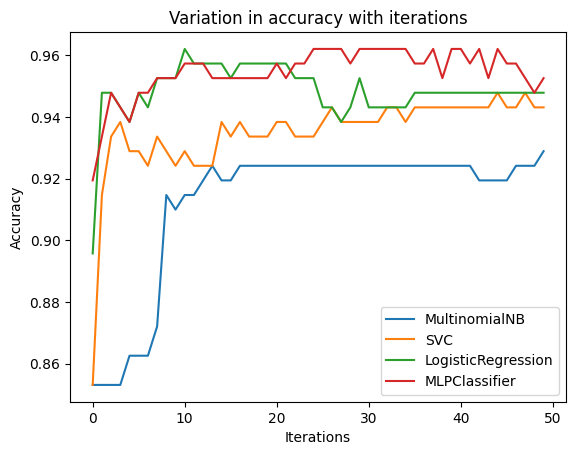

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.924171 |    0.959184 | 0.741935 |   0.80481  |
|  1 | SVC                |   0.938389 |    0.898753 | 0.843728 |   0.868157 |
|  2 | LogisticRegression |   0.952607 |    0.954325 | 0.852061 |   0.89382  |
|  3 | MLPClassifier      |   0.962085 |    0.946659 | 0.89767  |   0.920045 |

In [30]:
clf_fulltexts = [MultinomialNaiveBayes(), SVC(kernel='linear',probability=True),MultinomialLogisticRegression(),MLPClassifier()]
clf_inlinkss = [MultinomialNaiveBayes(), SVC(kernel='linear',probability=True),MultinomialLogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_fulltexts)):
    X_train_dup = X_train_L.copy()
    y_train_dup = y_train_L.copy()
    clf_fulltext, clf_inlinks, accuracy_list,precision_list,recall_list,f1_list = cotrain_binary(1,3,50,75,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltexts[i],clf_inlinkss[i],0,1,30,names[i]+"dataset_1")
    df = df._append({'Classifier':names[i],'Accuracy':accuracy_list[29],'Precision':precision_list[29],'Recall':recall_list[29],'F1 Score':f1_list[29]},ignore_index=True)
    plt.plot(accuracy_list,label=names[i])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with iterations')
plt.legend()
plt.show()
display(Markdown(df.to_markdown()))

### SELF-TRAINING

In [78]:
clf_fulltexts = [MultinomialNaiveBayes(), SVC(kernel='linear',probability=True),MultinomialLogisticRegression(),MLPClassifier()]
clf_inlinkss = [MultinomialNaiveBayes(), SVC(kernel='linear',probability=True),MultinomialLogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df2 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_fulltexts)):
    X_train_dup = X_train_L.copy()
    y_train_dup = y_train_L.copy()
    clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list = self_training_binary(1,3,30,75,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltexts[i],clf_inlinkss[i])
    df2 = df2._append({'Classifier':names[i],'Accuracy':accuracy_list[-1],'Precision':precision_list[-1],'Recall':recall_list[-1],'F1 Score':f1_list[-1]},ignore_index=True)

display(Markdown(df2.to_markdown()))

/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-pac

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.919431 |    0.956853 | 0.725806 |   0.788565 |
|  1 | SVC                |   0.933649 |    0.963918 | 0.774194 |   0.83545  |
|  2 | LogisticRegression |   0.933649 |    0.93983  | 0.787545 |   0.841183 |
|  3 | MLPClassifier      |   0.933649 |    0.861934 | 0.881004 |   0.871072 |

#### SUPERVISED LEARNING

In [32]:
clf_fulltexts = [MultinomialNaiveBayes(), SVC(kernel='linear',probability=True),MultinomialLogisticRegression(),MLPClassifier()]
clf_inlinkss = [MultinomialNaiveBayes(), SVC(kernel='linear',probability=True),MultinomialLogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df1 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

fulltext_t = []
inlinks_t = []

for i in range(len(X_train_L1)):
    fulltext_t.append(X_train_L1[i]['view1'])
    inlinks_t.append(X_train_L1[i]['view2'])

for i in range(len(clf_fulltexts)):
    clf_fulltext = clf_fulltexts[i]
    clf_inlinks = clf_inlinkss[i]
    clf_fulltext.fit(fulltext_t,y_train_L1)
    clf_inlinks.fit(inlinks_t,y_train_L1)
    acc,pre,rec,f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks)
    df1 = df1._append({'Classifier':names[i],'Accuracy':acc,'Precision':pre,'Recall':rec,'F1 Score':f1},ignore_index=True)
    
display(Markdown(df1.to_markdown()))

/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.853081 |    0.42654  | 0.5      |   0.460358 |
|  1 | SVC                |   0.838863 |    0.425481 | 0.491667 |   0.456186 |
|  2 | LogisticRegression |   0.895735 |    0.787343 | 0.84543  |   0.811607 |
|  3 | MLPClassifier      |   0.919431 |    0.847678 | 0.819265 |   0.832516 |

### COMPARING COTRAINING, SUPERVISED LEARNING AND SELF-TRAINING

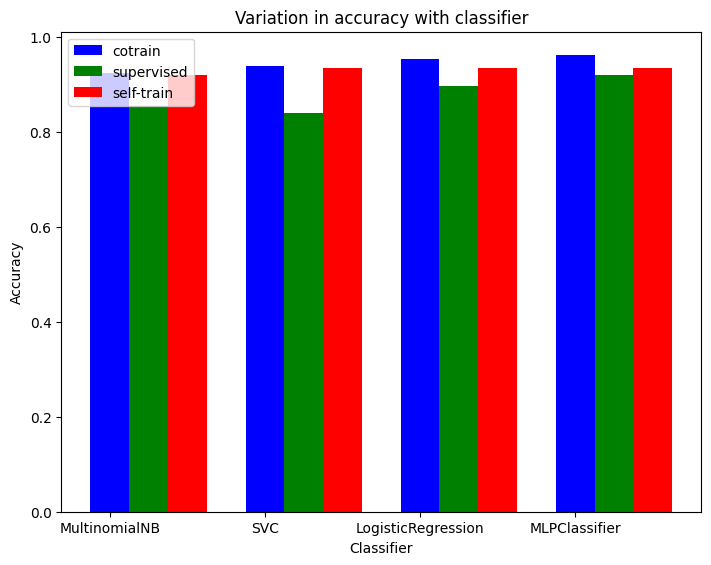

In [82]:
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
cotrain_acc = df['Accuracy'].tolist()
supervised_acc = df1['Accuracy'].tolist()
self_train_acc = df2['Accuracy'].tolist()
X = np.arange(len(names))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, cotrain_acc, color = 'b', width = 0.25)
ax.bar(X + 0.25, supervised_acc, color = 'g', width = 0.25)
ax.bar(X + 0.50, self_train_acc, color = 'r', width = 0.25)
ax.legend(labels=['cotrain','supervised','self-train'])
plt.xticks(X, names)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with classifier')
plt.show()

### WEB DATA (MULTI-CLASS)

In [40]:
X_fulltext = []
Y_fulltext = []
X_inlink = []
Y_inlink = []

for filename in os.listdir('data/course-cotrain-data/fulltext/non-course'):
    for folder in os.listdir('data/webkb'):
        if folder == 'department':
            continue
        for folder1 in os.listdir('data/webkb/' + folder):
            if filename in os.listdir('data/webkb/' + folder + '/' + folder1):
                Y_fulltext.append(folder)
                X_fulltext.append(get_text('data/webkb/' + folder + '/' + folder1 + '/' + filename))
                break
            else:
                continue

for filename in os.listdir('data/course-cotrain-data/inlinks/non-course'):
    for folder in os.listdir('data/webkb'):
        if folder == 'department':
            continue
        for folder1 in os.listdir('data/webkb/' + folder):
            if filename in os.listdir('data/webkb/' + folder + '/' + folder1):
                Y_inlink.append(folder)
                X_inlink.append(get_text('data/course-cotrain-data/inlinks/non-course/'+filename))
                break
            else:
                continue

for filename in os.listdir('data/course-cotrain-data/fulltext/course'):
    X_fulltext.append(get_text('data/course-cotrain-data/fulltext/course/'+filename))
    Y_fulltext.append('course')

for filename in os.listdir('data/course-cotrain-data/inlinks/course'):
    X_inlink.append(get_text('data/course-cotrain-data/inlinks/course/'+filename))
    Y_inlink.append('course')   

X_fulltext, vocab_fulltext = get_bag_of_words(X_fulltext)
X_inlink, vocab_inlinks = get_bag_of_words(X_inlink)

X_fulltext = X_fulltext.toarray()
X_inlink = X_inlink.toarray()

# label encoding
labelencoder = LabelEncoder()
Y_fulltext = labelencoder.fit_transform(Y_fulltext)
Y_inlink = labelencoder.fit_transform(Y_inlink)

Y_fulltext = np.array(Y_fulltext)
Y_inlink = np.array(Y_inlink)

In [41]:
data = {'x':[], 'y':[]}
for i in range(len(X_fulltext)):
    data['x'].append({'view1':X_fulltext[i], 'view2':X_inlink[i]})
    data['y'].append(Y_fulltext[i])

# train test split
X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=0,shuffle=True)

In [ ]:
# saving test data
pickle.dump(X_test,open('test_data/X_test_dataset2','wb'))
pickle.dump(y_test,open('test_data/y_test_dataset2','wb'))

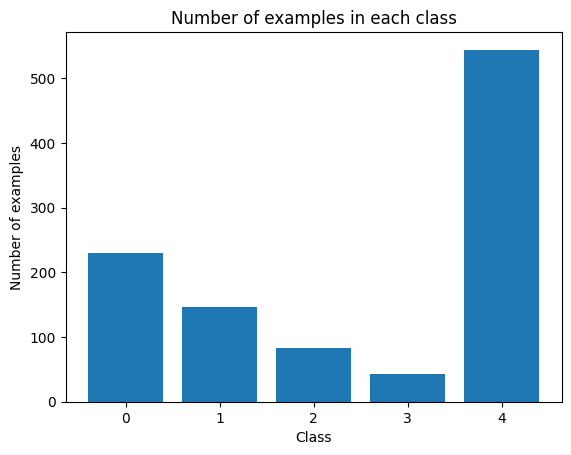

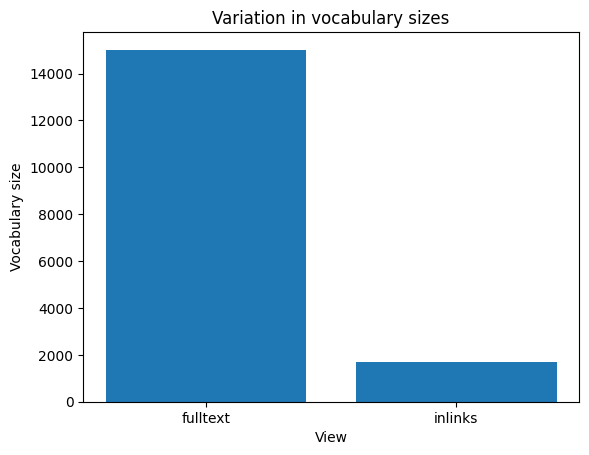

In [43]:
import matplotlib.pyplot as plt
plt.bar(['0','1','2','3','4'],[np.sum(Y_fulltext==0),np.sum(Y_fulltext==1),np.sum(Y_fulltext==2),np.sum(Y_fulltext==3),np.sum(Y_fulltext==4)])
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Number of examples in each class')
plt.show()

#plot of vocabulary size vs view
plt.bar(['fulltext','inlinks'],[len(vocab_fulltext),len(vocab_inlinks)])
plt.xlabel('View')
plt.ylabel('Vocabulary size')
plt.title('Variation in vocabulary sizes')
plt.show()

In [45]:
# diving X_train into L and U : L has 5 0's, 3 1's, 2 2's, 1 3's, 12 4's
X_train_L = []
X_train_U = []
y_train_L = []
y_train_U = []
X_train_L1 = []
y_train_L1 = []

count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0

for i in range(len(X_train)):
    if y_train[i] == 0 and count_0 < 5:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_0 += 1
    elif y_train[i] == 1 and count_1 < 3:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_1 += 1
    elif y_train[i] == 2 and count_2 < 2:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_2 += 1
    elif y_train[i] == 3 and count_3 < 1:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_3 += 1
    elif y_train[i] == 4 and count_4 < 12:
        X_train_L.append(X_train[i])
        y_train_L.append(y_train[i])
        X_train_L1.append(X_train[i])
        y_train_L1.append(y_train[i])
        count_4 += 1
    else:
        X_train_U.append(X_train[i])
        y_train_U.append(y_train[i])

### COTRAINING

/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-pac

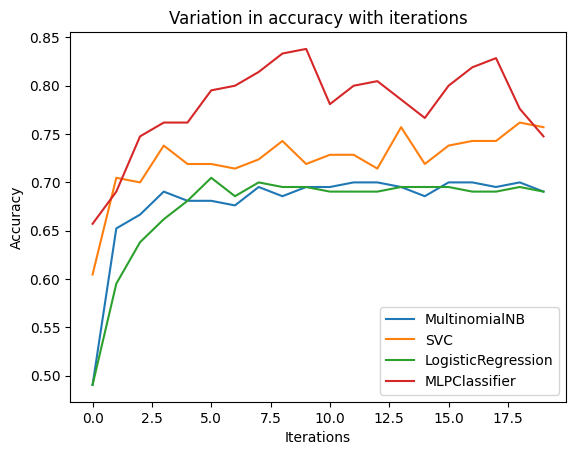

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.695238 |    0.319192 | 0.364096 |   0.331831 |
|  1 | SVC                |   0.719048 |    0.405032 | 0.391202 |   0.366383 |
|  2 | LogisticRegression |   0.695238 |    0.518758 | 0.373244 |   0.365695 |
|  3 | MLPClassifier      |   0.838095 |    0.638137 | 0.624647 |   0.629245 |

In [46]:
arr = [5,3,2,1,12]
clf_fulltexts = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
clf_inlinkss = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_fulltexts)):
    X_train_dup = X_train_L.copy()
    y_train_dup = y_train_L.copy()
    clf_fulltext, clf_inlinks, accuracy_list,precision_list,recall_list,f1_list = cotrain_multi_class(arr,20,150,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltexts[i],clf_inlinkss[i],1,10,names[i]+"dataset_2")
    df = df._append({'Classifier':names[i],'Accuracy':accuracy_list[9],'Precision':precision_list[9],'Recall':recall_list[9],'F1 Score':f1_list[9]},ignore_index=True)
    plt.plot(accuracy_list,label=names[i])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with iterations')
plt.legend()
plt.show()
display(Markdown(df.to_markdown()))

### SELF-TRAINING

In [69]:
arr = [5,3,2,1,12]
clf_fulltexts = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
clf_inlinkss = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df2 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_fulltexts)):
    X_train_dup = X_train_L.copy()
    y_train_dup = y_train_L.copy()
    clf_fulltext, clf_inlinks, accuracy_list, precision_list, recall_list, f1_list = self_train_multi_class(arr,20,150,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_fulltexts[i],clf_inlinkss[i])
    df2 = df2._append({'Classifier':names[i],'Accuracy':accuracy_list[-1],'Precision':precision_list[-1],'Recall':recall_list[-1],'F1 Score':f1_list[-1]},ignore_index=True)

display(Markdown(df2.to_markdown()))

/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shravya/.local/lib/python3.10/site-pac

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.714286 |    0.453302 | 0.383764 |   0.360126 |
|  1 | SVC                |   0.780952 |    0.688791 | 0.491808 |   0.516862 |
|  2 | LogisticRegression |   0.690476 |    0.717763 | 0.37903  |   0.385133 |
|  3 | MLPClassifier      |   0.785714 |    0.609515 | 0.542113 |   0.560281 |

### SUPERVISED LEARNING

In [50]:
clf_fulltexts = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
clf_inlinkss = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df1 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

fulltext_t = []
inlinks_t = []

for i in range(len(X_train_L1)):
    fulltext_t.append(X_train_L1[i]['view1'])
    inlinks_t.append(X_train_L1[i]['view2'])

for i in range(len(clf_fulltexts)):
    clf_fulltext = clf_fulltexts[i]
    clf_inlinks = clf_inlinkss[i]
    clf_fulltext.fit(fulltext_t,y_train_L1)
    clf_inlinks.fit(inlinks_t,y_train_L1)
    acc,pre,rec,f1 = accuracy(X_test, y_test, clf_fulltext,clf_inlinks)
    df1 = df1._append({'Classifier':names[i],'Accuracy':acc,'Precision':pre,'Recall':rec,'F1 Score':f1},ignore_index=True)

display(Markdown(df1.to_markdown()))

/home/shravya/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.490476 |   0.0980952 | 0.2      |   0.131629 |
|  1 | SVC                |   0.585714 |   0.308421  | 0.275472 |   0.250203 |
|  2 | LogisticRegression |   0.490476 |   0.0980952 | 0.2      |   0.131629 |
|  3 | MLPClassifier      |   0.657143 |   0.464249  | 0.355368 |   0.352128 |

### COMPARING COTRAINING AND SUPERVISED LEARNING

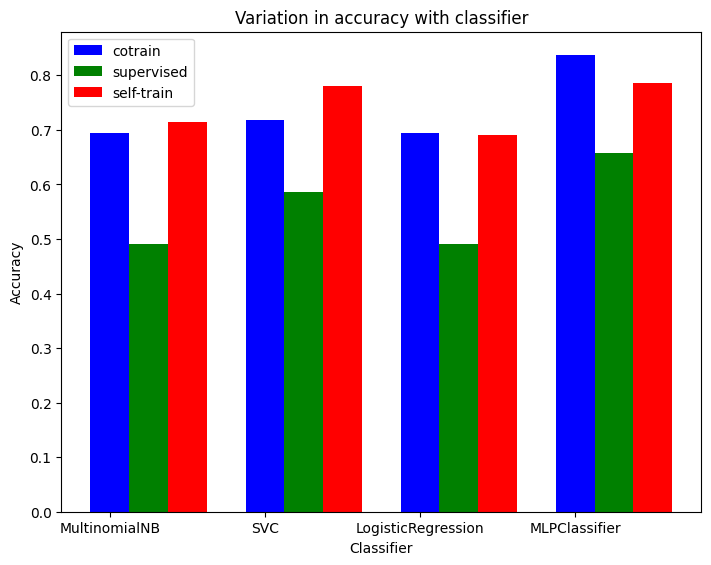

In [71]:
import matplotlib.pyplot as plt
import numpy as np

names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
cotrain_acc = df['Accuracy'].tolist()
supervised_acc = df1['Accuracy'].tolist()
self_train_acc = df2['Accuracy'].tolist()
X = np.arange(len(names))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, cotrain_acc, color = 'b', width = 0.25)
ax.bar(X + 0.25, supervised_acc, color = 'g', width = 0.25)
ax.bar(X + 0.50, self_train_acc, color = 'r', width = 0.25)
ax.legend(labels=['cotrain','supervised','self-train'])
plt.xticks(X, names)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with classifier')
plt.show()

### NEWS CATEGORY DATASET

In [43]:
import json

X_headline = []
X_shortdesc = []
Y = []

json_file_path = 'data/News_Category_Dataset_v3.json'

with open(json_file_path, 'r') as file:
    for line in file:
        entry = json.loads(line)
        X_headline.append(entry['headline'])
        X_shortdesc.append(entry['short_description'])
        Y.append(entry['category'])

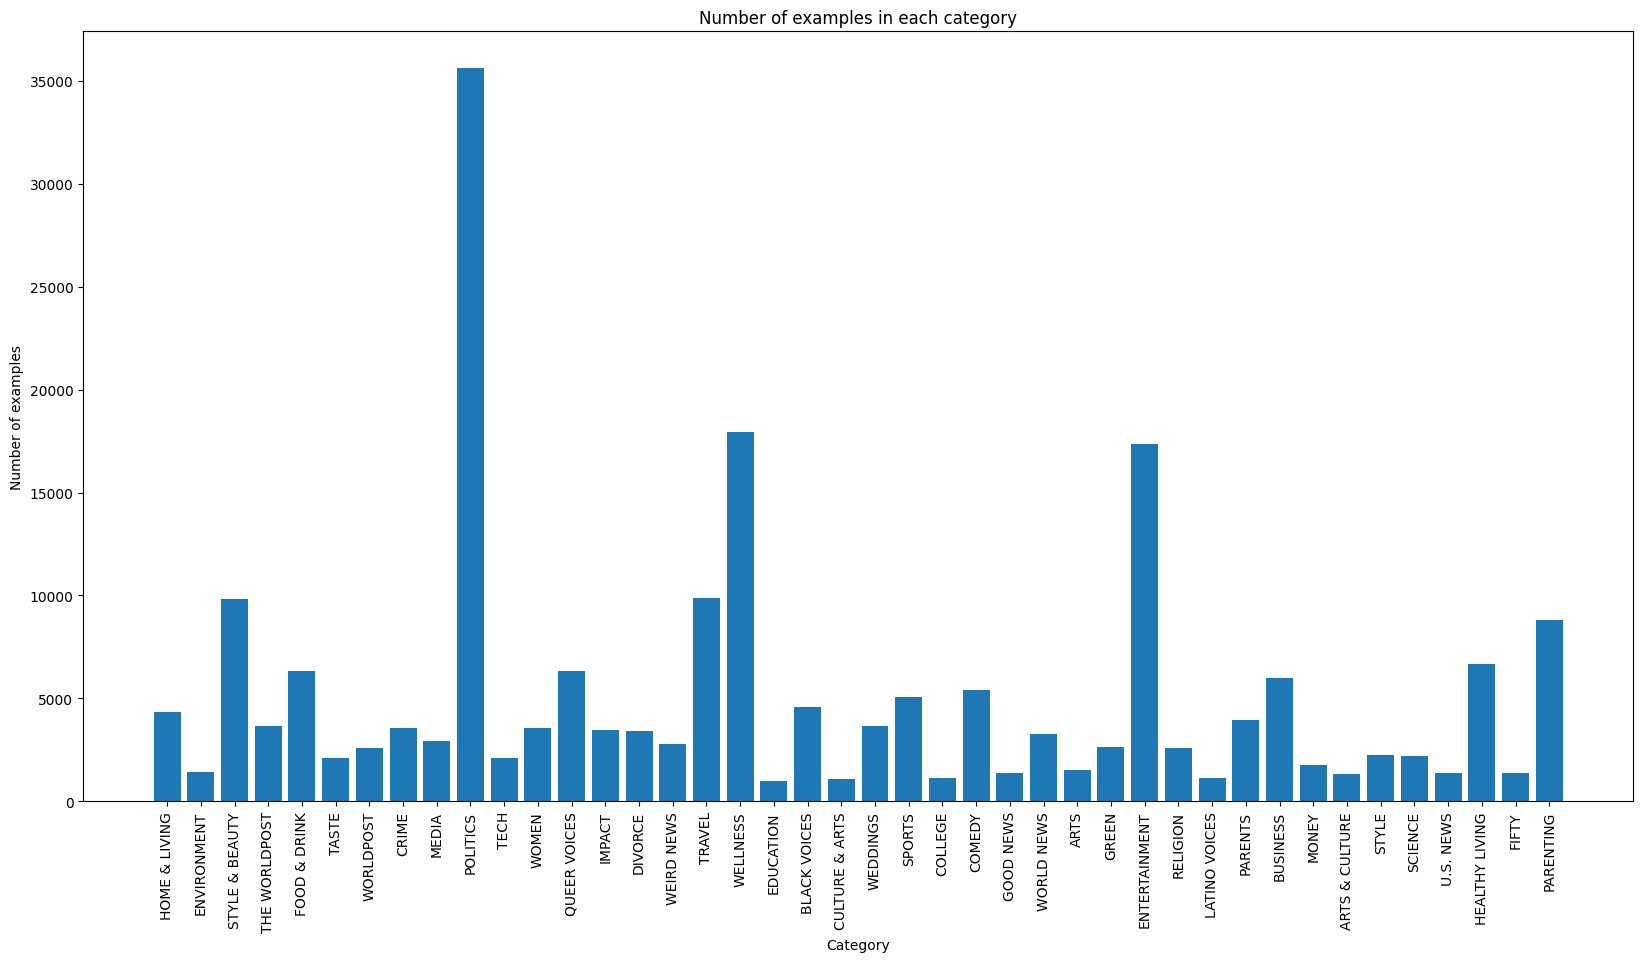

In [44]:
# unique categories
labels = list(set(Y))
fig = plt.figure(figsize=(20, 10))
plt.bar(labels,[Y.count(x) for x in labels])
plt.xlabel('Category')
plt.ylabel('Number of examples')
plt.xticks(rotation=90)
plt.title('Number of examples in each category')
plt.show()

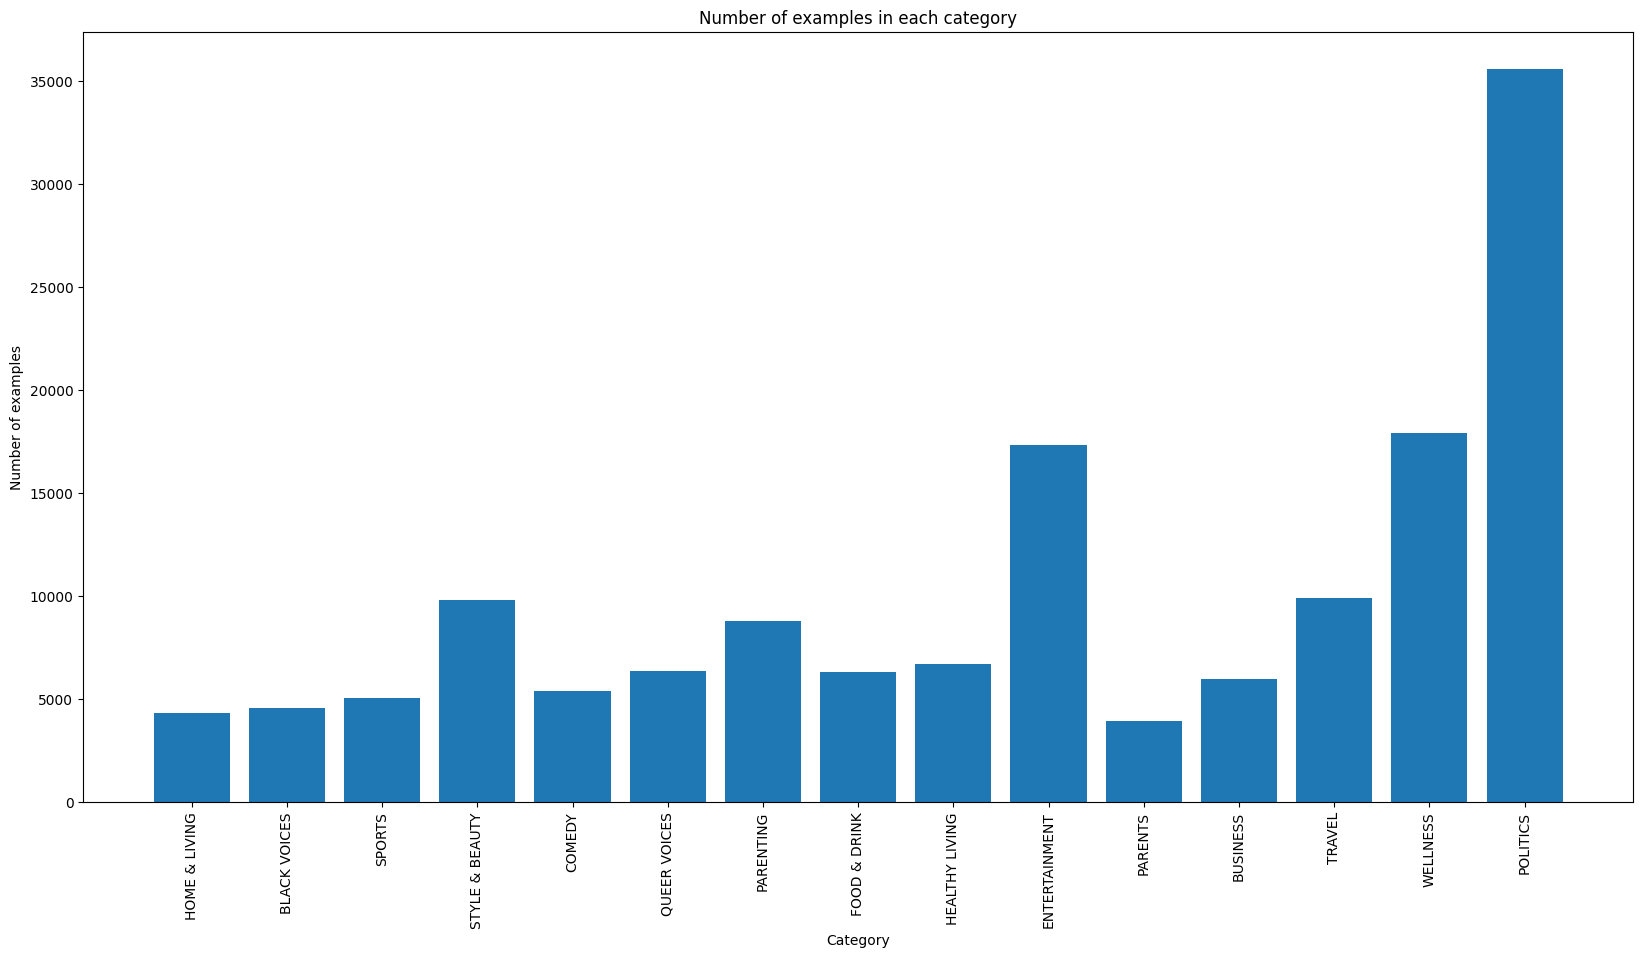

In [45]:
# top 15 categories
Y_top15 = []
X_headline_top15 = []
X_shortdesc_top15 = []

for i in range(len(Y)):
    if Y[i] in ['POLITICS','WELLNESS','ENTERTAINMENT','TRAVEL','STYLE & BEAUTY','PARENTING','HEALTHY LIVING','QUEER VOICES','FOOD & DRINK','BUSINESS','COMEDY','SPORTS','BLACK VOICES','HOME & LIVING','PARENTS']:
        Y_top15.append(Y[i])
        X_headline_top15.append(X_headline[i])
        X_shortdesc_top15.append(X_shortdesc[i])

top_15_labels = list(set(Y_top15))
fig = plt.figure(figsize=(20, 10))
plt.bar(top_15_labels,[Y_top15.count(x) for x in top_15_labels])
plt.xlabel('Category')
plt.ylabel('Number of examples')
plt.xticks(rotation=90)
plt.title('Number of examples in each category')
plt.show()

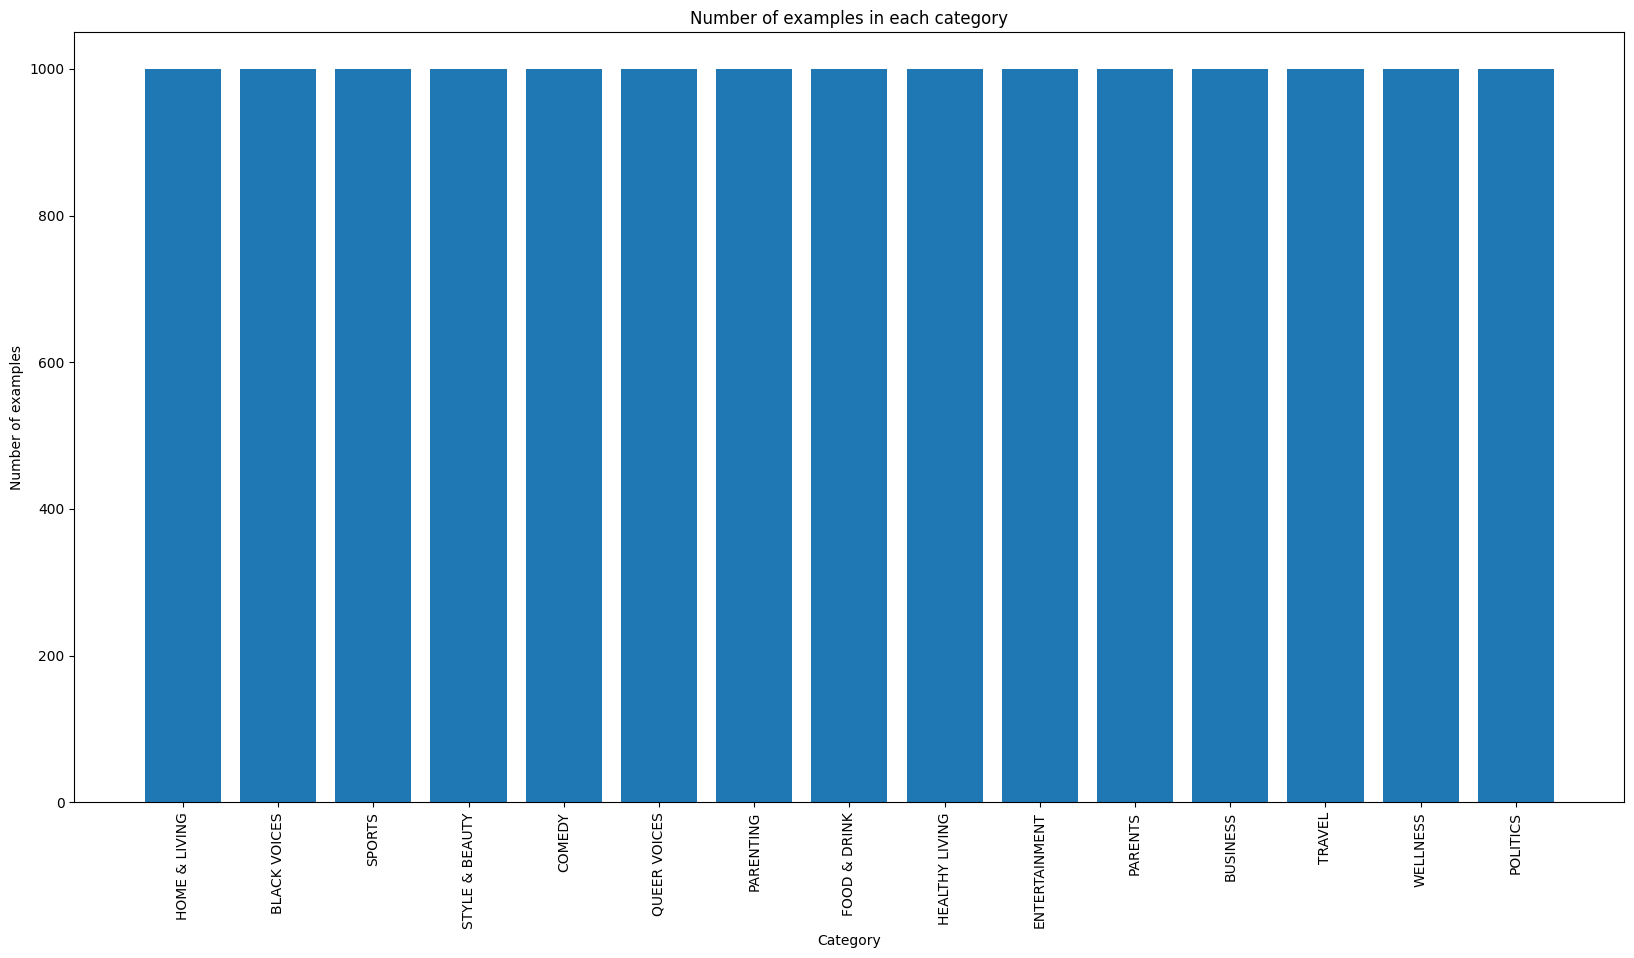

In [46]:
# balancing data
X_headline_balanced = []
X_shortdesc_balanced = []
Y_balanced = []

s = 1000

for i in range(len(Y_top15)):
    if Y_balanced.count(Y_top15[i]) < s:
        Y_balanced.append(Y_top15[i])
        X_headline_balanced.append(X_headline_top15[i])
        X_shortdesc_balanced.append(X_shortdesc_top15[i])

fig = plt.figure(figsize=(20, 10))
plt.bar(top_15_labels,[Y_balanced.count(x) for x in top_15_labels])
plt.xlabel('Category')
plt.ylabel('Number of examples')
plt.xticks(rotation=90)
plt.title('Number of examples in each category')
plt.show()

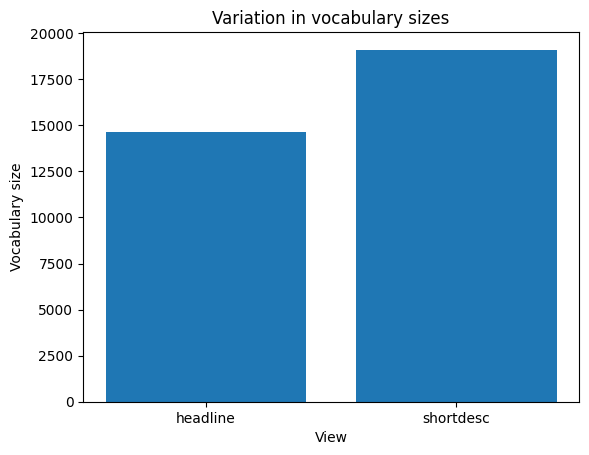

In [47]:
# bag of words
X_headline,vocab_headline = get_bag_of_words(X_headline_balanced)
X_shortdesc,vocab_shortdesc = get_bag_of_words(X_shortdesc_balanced)

X_headline = X_headline.toarray()
X_shortdesc = X_shortdesc.toarray()

# label encoding
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(Y_balanced)
Y = np.array(Y)

data = {'x':[], 'y':[]}
for i in range(len(X_headline)):
    data['x'].append({'view1':X_headline[i], 'view2':X_shortdesc[i]})
    data['y'].append(Y[i])

# plotting vocabulary size vs view
plt.bar(['headline','shortdesc'],[len(vocab_headline),len(vocab_shortdesc)])
plt.xlabel('View')
plt.ylabel('Vocabulary size')
plt.title('Variation in vocabulary sizes')
plt.show()

# train test split
X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=0,shuffle=True)


In [48]:
# splitting X_train into L and U : L has 10 samples from each category and U has the rest
X_train_L = []
X_train_L1 = []
X_train_U = []
y_train_L = []
y_train_L1 = []
y_train_U = []

count = [0 for i in range(len(top_15_labels))]

for i in range(len(X_train)):
    if count[y_train[i]] < 10:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count[y_train[i]] += 1
    else:
        X_train_U.append(X_train[i])
        y_train_U.append(y_train[i])

### COTRAINING

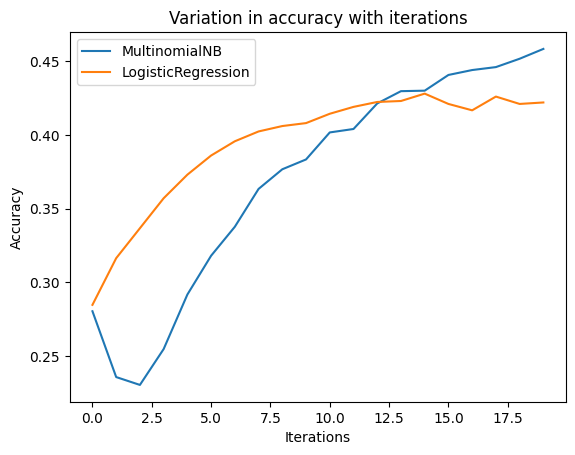

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.383333 |    0.470196 | 0.382084 |   0.362707 |
|  1 | LogisticRegression |   0.408    |    0.4021   | 0.405823 |   0.387177 |

In [83]:
arr = [5 for i in range(len(top_15_labels))]
clf_headlines = [MultinomialNaiveBayes(), MultinomialLogisticRegression()]
clf_shortdescs = [MultinomialNaiveBayes(), MultinomialLogisticRegression()]
names = ['MultinomialNB','LogisticRegression']
df = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])
for i in range(len(clf_headlines)):
    clf_headline, clf_shortdesc, accuracy_list,precision_list,recall_list,f1_list = cotrain_multi_class(arr,20,500,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_headlines[i],clf_shortdescs[i],1,10,names[i]+"dataset_3")
    df = df._append({'Classifier':names[i],'Accuracy':accuracy_list[9],'Precision':precision_list[9],'Recall':recall_list[9],'F1 Score':f1_list[9]},ignore_index=True)
    plt.plot(accuracy_list,label=names[i])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with iterations')
plt.legend()
plt.show()
display(Markdown(df.to_markdown()))

#### SELF-TRAINING

In [85]:
arr = [5 for i in range(len(top_15_labels))]
clf_headlines = [MultinomialNaiveBayes(), MultinomialLogisticRegression()]
clf_shortdescs = [MultinomialNaiveBayes(), MultinomialLogisticRegression()]
names = ['MultinomialNB','LogisticRegression']
df2 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_headlines)):
    clf_headline, clf_shortdesc, accuracy_list, precision_list, recall_list, f1_list = self_train_multi_class(arr,10,500,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_headlines[i],clf_shortdescs[i])
    df2 = df2._append({'Classifier':names[i],'Accuracy':accuracy_list[-1],'Precision':precision_list[-1],'Recall':recall_list[-1],'F1 Score':f1_list[-1]},ignore_index=True)

display(Markdown(df2.to_markdown()))

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.356333 |    0.529908 | 0.356813 |   0.341146 |
|  1 | LogisticRegression |   0.408667 |    0.414241 | 0.407984 |   0.391951 |

### SUPERVISED LEARNING

In [86]:
short_desc = []
headline = []

for i in range(len(X_train_L1)):
    short_desc.append(X_train_L1[i]['view2'])
    headline.append(X_train_L1[i]['view1'])

arr = [5 for i in range(len(top_15_labels))]
clf_headlines = [MultinomialNaiveBayes(), MultinomialLogisticRegression()]
clf_shortdescs = [MultinomialNaiveBayes(), MultinomialLogisticRegression()]
names = ['MultinomialNB','LogisticRegression']

df1 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_headlines)):
    clf_headline = clf_headlines[i]
    clf_shortdesc = clf_shortdescs[i]
    clf_headline.fit(headline,y_train_L1)
    clf_shortdesc.fit(short_desc,y_train_L1)
    acc,pre,rec,f1 = accuracy(X_test, y_test, clf_headline,clf_shortdesc)
    df1 = df1._append({'Classifier':names[i],'Accuracy':acc,'Precision':pre,'Recall':rec,'F1 Score':f1},ignore_index=True)

display(Markdown(df1.to_markdown()))

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.280333 |    0.280497 | 0.27808  |   0.274581 |
|  1 | LogisticRegression |   0.284667 |    0.283885 | 0.282199 |   0.277191 |

### COMPARING COTRAINING AND SUPERVISED LEARNING

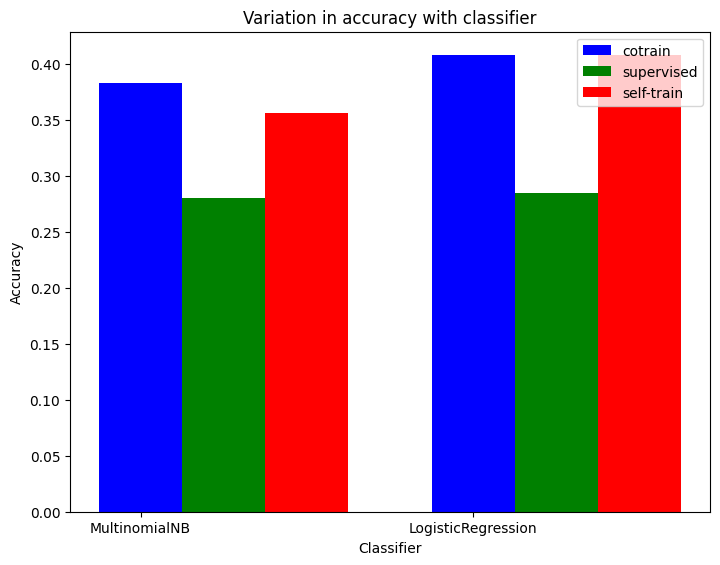

In [87]:
names = ['MultinomialNB','LogisticRegression']
cotrain_acc = df['Accuracy'].tolist()
supervised_acc = df1['Accuracy'].tolist()
self_train_acc = df2['Accuracy'].tolist()
X = np.arange(len(names))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, cotrain_acc, color = 'b', width = 0.25)
ax.bar(X + 0.25, supervised_acc, color = 'g', width = 0.25)
ax.bar(X + 0.50, self_train_acc, color = 'r', width = 0.25)
ax.legend(labels=['cotrain','supervised','self-train'])
plt.xticks(X, names)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with classifier')
plt.show()

### SENTENCE POLARITY DATASET

In [ ]:
X_view1 = []
Y = []

with open('data/rt-polaritydata/rt-polarity.pos', 'rb') as pos_file:
    positive_sentences = pos_file.readlines()
    positive_sentences = [sentence.decode('latin-1', errors='ignore') for sentence in positive_sentences]
    X_view1.extend(positive_sentences)
    Y.extend(['positive'] * len(positive_sentences))

with open('data/rt-polaritydata/rt-polarity.neg', 'rb') as neg_file:
    negative_sentences = neg_file.readlines()
    negative_sentences = [sentence.decode('latin-1', errors='ignore') for sentence in negative_sentences]
    X_view1.extend(negative_sentences)
    Y.extend(['negative'] * len(negative_sentences))

for i in range(5):
    print(f"Sentence: {X_view1[i].strip()}, Label: {Y[i]}")

import numpy as np
X_view1 = np.array(X_view1)
Y = np.array(Y)

Sentence: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal ., Label: positive
Sentence: the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth ., Label: positive
Sentence: effective but too-tepid biopic, Label: positive
Sentence: if you sometimes like to go to the movies to have fun , wasabi is a good place to start ., Label: positive
Sentence: emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one ., Label: positive


In [ ]:
# for view2 generate the antonymous sentence for each sentence in view1 using the wordnet library
def get_antonymous_sentence(sentence):
    tokens = word_tokenize(sentence)
    tagged_tokens = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    antonymous_tokens = []
    for token in tagged_tokens:
        if token[1].startswith('J'):
            antonymous_tokens.append(get_antonymous(token[0], 'a'))
        elif token[1].startswith('V'):
            antonymous_tokens.append(get_antonymous(token[0], 'v'))
        elif token[1].startswith('N'):
            antonymous_tokens.append(get_antonymous(token[0], 'n'))
        elif token[1].startswith('R'):
            antonymous_tokens.append(get_antonymous(token[0], 'r'))
        else:
            antonymous_tokens.append(token[0])
    antonymous_tokens = [token for token in antonymous_tokens if token not in set(stopwords.words('english'))]
    antonymous_sentence = ' '.join(antonymous_tokens)
    return antonymous_sentence

def get_antonymous(word, pos):
    antonyms = []
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            if lemma.antonyms():
                antonyms.append(lemma.antonyms()[0].name())
    if len(antonyms) == 0:
        return word
    else:
        return antonyms[0]

In [ ]:
# generating the antonymous sentences in view2
X_view2 = []
for sentence in X_view1:
    X_view2.append(get_antonymous_sentence(sentence))


In [ ]:
print(f"Sentence: {X_view1[3].strip()}")
print(f"Antonymous Sentence: {X_view2[3]}")

Sentence: if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
Antonymous Sentence: sometimes like stay_in_place movies lack fun , wasabi differ bad place end .


In [ ]:
# getting the bag of words for view1 and view2

X_view1,vocab_view1 = get_bag_of_words(X_view1)
X_view2,vocab_view2 = get_bag_of_words(X_view2)

X_view1 = X_view1.toarray()
X_view2 = X_view2.toarray()

# label encoding
labelencoder = LabelEncoder()
Y = labelencoder.fit_transform(Y)

Y = np.array(Y)

data = {'x':[], 'y':[]}
for i in range(len(X_view1)):
    data['x'].append({'view1':X_view1[i], 'view2':X_view2[i]})
    data['y'].append(Y[i])


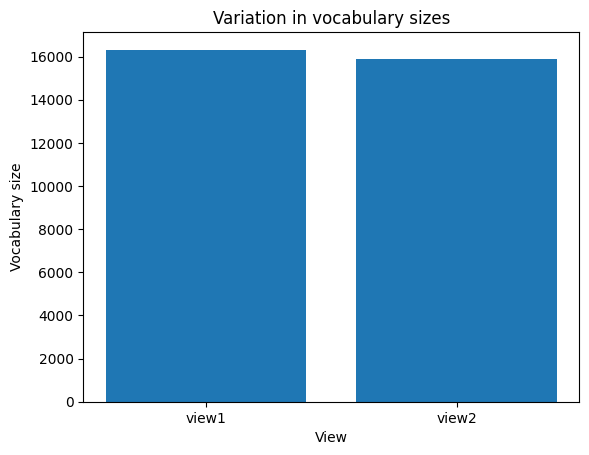

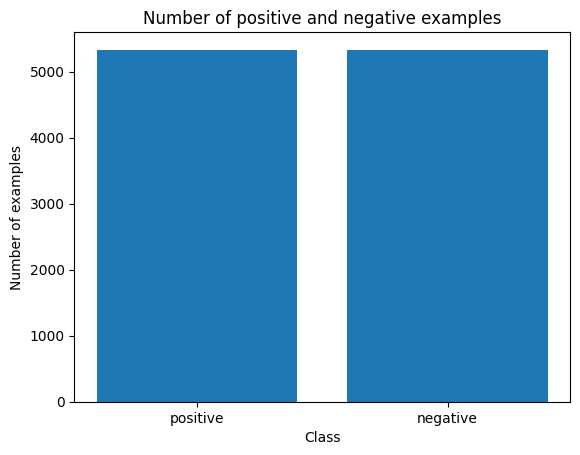

In [ ]:
# plot of vocabulary size vs view
plt.bar(['view1','view2'],[len(vocab_view1),len(vocab_view2)])
plt.xlabel('View')
plt.ylabel('Vocabulary size')
plt.title('Variation in vocabulary sizes')
plt.show()

#plot of number of positive and negative examples
plt.bar(['positive','negative'],[np.sum(Y==0),np.sum(Y==1)])
plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Number of positive and negative examples')
plt.show()

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=0,shuffle=True)

# taking 10 Labelled examples from each class
X_train_L = []
X_train_L1 = []
X_train_U = []
y_train_L = []
y_train_L1 = []
y_train_U = []

count_0 = 0
count_1 = 0

for i in range(len(X_train)):
    if y_train[i] == 0 and count_0 < 10:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count_0 += 1
    elif y_train[i] == 1 and count_1 < 10:
        X_train_L.append(X_train[i])
        X_train_L1.append(X_train[i])
        y_train_L.append(y_train[i])
        y_train_L1.append(y_train[i])
        count_1 += 1
    else:
        X_train_U.append(X_train[i])
        y_train_U.append(y_train[i])


### COTRAINING

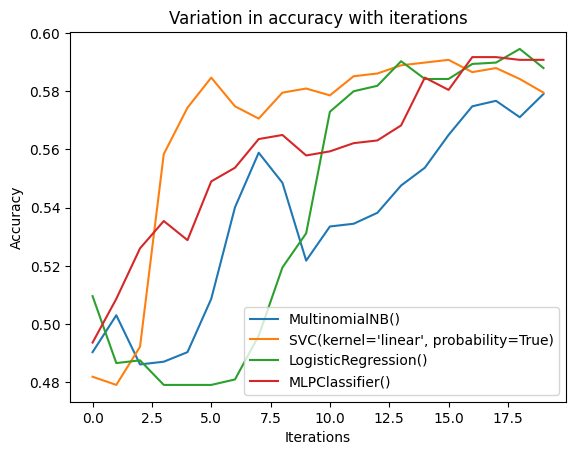

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.55368  |    0.589762 | 0.564816 |   0.525593 |
|  1 | SVC                |   0.58978  |    0.588879 | 0.586223 |   0.584782 |
|  2 | LogisticRegression |   0.584154 |    0.592074 | 0.588504 |   0.581495 |
|  3 | MLPClassifier      |   0.584623 |    0.597468 | 0.590443 |   0.579069 |

In [88]:
clf_view1 = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
clf_view2 = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])
for i in range(len(clf_view1)):
    clf_v1, clf_v2, accuracy_list,precision_list,recall_list,f1_list = cotrain_binary(5,5,20,250,X_train_L,X_train_U,y_train_L,y_train_U, X_test, y_test, clf_view1[i],clf_view2[i],1,1,15,names[i]+"dataset_4")
    df = df._append({'Classifier':names[i],'Accuracy':accuracy_list[14],'Precision':precision_list[14],'Recall':recall_list[14],'F1 Score':f1_list[14]},ignore_index=True)
    plt.plot(accuracy_list,label=clf_view1[i])
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with iterations')
plt.legend()
plt.show()
display(Markdown(df.to_markdown()))

#### SELF-TRAINING

In [89]:
clf_view1 = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
clf_view2 = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]

names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df2 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

for i in range(len(clf_view1)):
    X_train_dup = X_train_L.copy()
    y_train_dup = y_train_L.copy()
    clf_v1, clf_v2, accuracy_list, precision_list, recall_list, f1_list = self_training_binary(5,5,20,250,X_train_dup,X_train_U,y_train_dup,y_train_U, X_test, y_test, clf_view1[i],clf_view2[i],flag=1)
    df2 = df2._append({'Classifier':names[i],'Accuracy':accuracy_list[-1],'Precision':precision_list[-1],'Recall':recall_list[-1],'F1 Score':f1_list[-1]},ignore_index=True)

display(Markdown(df2.to_markdown()))

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.574308 |    0.597188 | 0.58258  |   0.561028 |
|  1 | SVC                |   0.58181  |    0.601183 | 0.589193 |   0.57187  |
|  2 | LogisticRegression |   0.562588 |    0.58756  | 0.571643 |   0.545636 |
|  3 | MLPClassifier      |   0.56962  |    0.581404 | 0.575454 |   0.563771 |

#### SUPERVISED LEARNING

In [90]:
# supervised learning
clf_view1 = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
clf_view2 = [MultinomialNB(),SVC(kernel='linear',probability=True),LogisticRegression(),MLPClassifier()]
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
df1 = pd.DataFrame(columns=['Classifier','Accuracy','Precision','Recall','F1 Score'])

view1_t = []
view2_t = []

for i in range(len(X_train_L1)):
    view1_t.append(X_train_L1[i]['view1'])
    view2_t.append(X_train_L1[i]['view2'])

for i in range(len(clf_view1)):
    clf_v1 = clf_view1[i]
    clf_v2 = clf_view2[i]
    clf_v1.fit(view1_t,y_train_L1)
    y_ = [1 - value for value in y_train_L1]
    clf_v2.fit(view2_t,y_)
    acc,pre,rec,f1 = accuracy(X_test, y_test, clf_v1,clf_v2,flag=1)
    df1 = df1._append({'Classifier':names[i],'Accuracy':acc,'Precision':pre,'Recall':rec,'F1 Score':f1},ignore_index=True)
    
display(Markdown(df1.to_markdown()))

|    | Classifier         |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:-------------------|-----------:|------------:|---------:|-----------:|
|  0 | MultinomialNB      |   0.490389 |    0.492066 | 0.492107 |   0.490172 |
|  1 | SVC                |   0.518519 |    0.511553 | 0.509311 |   0.48859  |
|  2 | LogisticRegression |   0.509611 |    0.499513 | 0.499624 |   0.473999 |
|  3 | MLPClassifier      |   0.489451 |    0.498651 | 0.498927 |   0.466761 |

### COMPARING COTRAINING AND SUPERVISED LEARNING

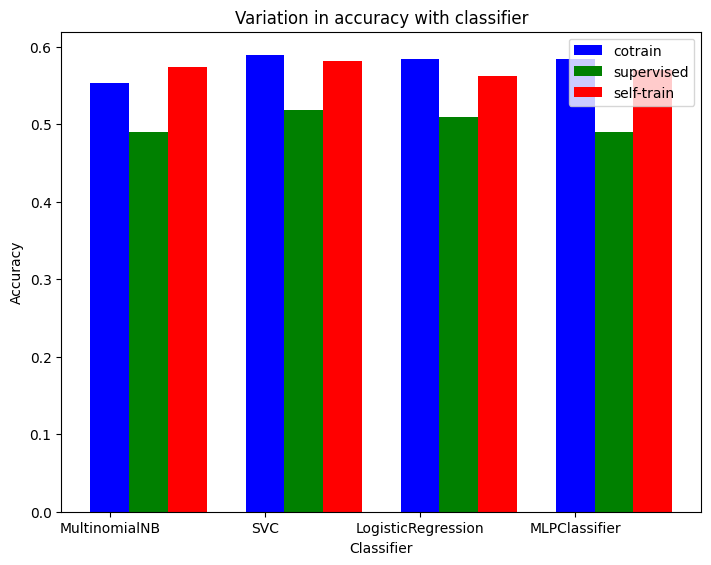

In [91]:
names = ['MultinomialNB','SVC','LogisticRegression','MLPClassifier']
cotrain_acc = df['Accuracy'].tolist()
supervised_acc = df1['Accuracy'].tolist()
self_train_acc = df2['Accuracy'].tolist()

X = np.arange(len(names))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, cotrain_acc, color = 'b', width = 0.25)
ax.bar(X + 0.25, supervised_acc, color = 'g', width = 0.25)
ax.bar(X + 0.50, self_train_acc, color = 'r', width = 0.25)
ax.legend(labels=['cotrain','supervised','self-train'])
plt.xticks(X, names)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Variation in accuracy with classifier')
plt.show()